In [106]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

from skimage.segmentation import clear_border
img = cv.imread('matricula_2.jpeg')
img_gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [107]:
kernel = np.ones((3,3), np.uint8)

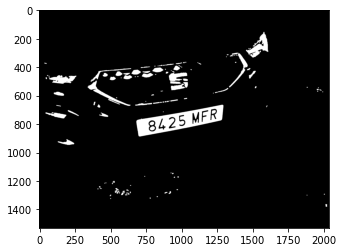

In [108]:
median = cv.medianBlur(img_gris, 3)
ret, th = cv.threshold(median, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
edge_touching_removed = clear_border(opening)
contours, hierarchy = cv.findContours(edge_touching_removed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
plt.imshow(edge_touching_removed, cmap="gray")

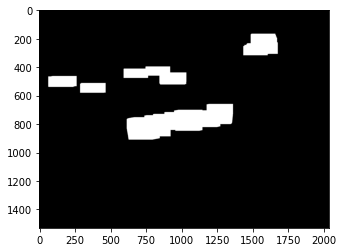

In [109]:
img_erosion = cv.erode(edge_touching_removed, kernel, iterations=7)
img_dilation = cv.dilate(img_erosion, kernel, iterations=7)
img_dilation = cv.dilate(img_dilation, np.ones((2,9), np.uint8), iterations=15)
img_dilation = cv.dilate(img_dilation, kernel, iterations=5)
plt.imshow(img_dilation, cmap="gray")

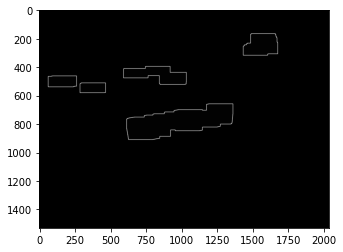

In [110]:
cnts,_=cv.findContours(cv.Canny(img_dilation,100,200),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
contornos =  cv.drawContours((img_dilation//255),cnts,-1,(100,100,100),2)
plt.imshow(contornos, cmap="gray")

In [111]:
contornos_millor=cnts[0]
area_max=0
for c in cnts:
    area = cv.contourArea(c)
    if area>area_max:#len(approx)==4 and area>4000:
        area_max=area
        contornos_millor=c
        x_esquerra,y_esquerra,largo,ancho = cv.boundingRect(c)

In [112]:
epsilon = 0.05*cv.arcLength(contornos_millor,True)
approx = cv.approxPolyDP(contornos_millor,epsilon,True)
#print(len(approx))
x,y,w,h = cv.boundingRect(approx)

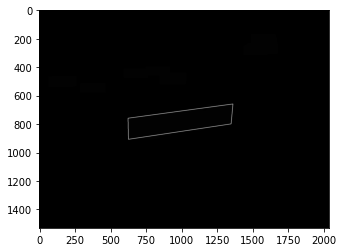

In [113]:
aux=cv.drawContours(img_dilation//255,[approx],0,(100,100,100),2)
plt.imshow(aux, cmap="gray")

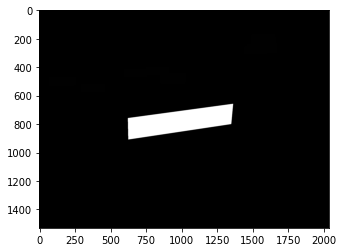

In [114]:
im_floodfill = ((aux>2) * aux).copy()
 
h, w = aux.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv.floodFill(im_floodfill, mask, (0,0), 255)
 
# Invert floodfilled image
im_floodfill_inv = cv.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = aux | im_floodfill_inv
 
plt.imshow( im_out,cmap="gray")

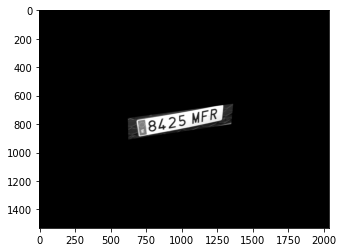

In [115]:
imagen_final=img_gris*(im_out>200)
plt.imshow(imagen_final,cmap="gray")

In [116]:
"""tamany=imagen_final.shape
x=0
y=0
valor=imagen_final[x,y]
while valor<1:
    x+=5
    if x>tamany[0]-1:
        x=0
        y+=1
    valor=imagen_final[x,y]
y_esquerra=y
x=0
y=0
valor=imagen_final[x,y]
while valor<1:
    y+=5
    if y>tamany[1]-1:
        y=0
        x+=1
    valor=imagen_final[x,y]
x_esquerra=x
x=0
y=tamany[1]-1
valor=imagen_final[x,y]
while valor<1:
    x+=5
    if x>tamany[0]-1:
        x=0
        y-=1
    valor=imagen_final[x,y]
y_dreta=y
x=tamany[0]-1
y=0
valor=imagen_final[x,y]
while valor<1:
    y+=5
    if y>tamany[1]-1:
        y=0
        x-=1
    valor=imagen_final[x,y]
x_dreta=x"""

'tamany=imagen_final.shape\nx=0\ny=0\nvalor=imagen_final[x,y]\nwhile valor<1:\n    x+=5\n    if x>tamany[0]-1:\n        x=0\n        y+=1\n    valor=imagen_final[x,y]\ny_esquerra=y\nx=0\ny=0\nvalor=imagen_final[x,y]\nwhile valor<1:\n    y+=5\n    if y>tamany[1]-1:\n        y=0\n        x+=1\n    valor=imagen_final[x,y]\nx_esquerra=x\nx=0\ny=tamany[1]-1\nvalor=imagen_final[x,y]\nwhile valor<1:\n    x+=5\n    if x>tamany[0]-1:\n        x=0\n        y-=1\n    valor=imagen_final[x,y]\ny_dreta=y\nx=tamany[0]-1\ny=0\nvalor=imagen_final[x,y]\nwhile valor<1:\n    y+=5\n    if y>tamany[1]-1:\n        y=0\n        x-=1\n    valor=imagen_final[x,y]\nx_dreta=x'

In [117]:
#plt.imshow(imagen_final[y_esquerra:y_esquerra+ancho,x_esquerra:x_esquerra+largo],cmap="gray")

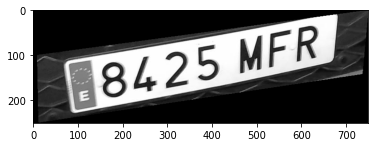

In [118]:
imagen_recortada=imagen_final[y_esquerra:y_esquerra+ancho,x_esquerra:x_esquerra+largo]
plt.imshow(imagen_recortada,cmap="gray")

https://es.stackoverflow.com/questions/141818/como-enderezo-una-imagen-en-python

https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/

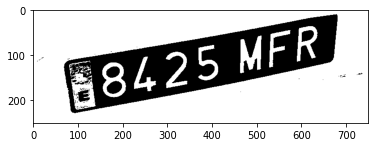

In [144]:

gray = cv.bitwise_not(imagen_recortada)
thresh = cv.threshold(gray, 0, 255,	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

plt.imshow(thresh,cmap="gray")

coords = np.column_stack(np.where(thresh > 0))
angle = cv.minAreaRect(coords)[-1]



if angle < -45:
	angle = -(90 + angle)

else:
	angle = -angle

(h, w) = imagen_recortada.shape[:2]
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, -angle, 1.0)
rotated = cv.warpAffine(imagen_recortada, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
 
#plt.imshow(girada,cmap="gray")


In [120]:
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

In [121]:
x1 = 

points_original = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype='float32')

SyntaxError: invalid syntax (<ipython-input-121-fa4991f258f9>, line 1)

In [ ]:
text = pytesseract.image_to_string(imagen_recortada)
print("hola",text)

hola 


In [ ]:
text = pytesseract.image_to_string(imagen_recortada,config='--psm 11')
print('PLACA: ',text)

PLACA:  


In [ ]:
import easyocr

In [ ]:
reader = easyocr.Reader(['en'], gpu = False)
text = reader.readtext(imagen_recortada)


In [ ]:
!pip install tesseract-ocr

  Preparing metadata (setup.py): started


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      running bdist_wheel
      running build
      running build_py
      file tesseract_ocr.py (for module tesseract_ocr) not found
      file tesseract_ocr.py (for module tesseract_ocr) not found
      running build_ext
      building 'tesseract_ocr' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tesseract-ocr
  error: subprocess-exited-with-error
  
  × Running setup.py install for tesseract-ocr did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      running install
      running build
      running build_py
      file tesseract_ocr.py (for module tesserac

  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
  Running setup.py install for tesseract-ocr: started
  Running setup.py install for tesseract-ocr: finished with status 'error'
